# Lab 3 — recommender systems

In [101]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pyspark.mllib.recommendation as rec

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
myRatings = []
with open('my-ratings.txt','r') as file:
    for line in file:
        myRatings.append(json.loads(line))
myRatings = sc.parallelize(myRatings)
data = data.union(myRatings)
numRatings = data.count()
numUsers = data.map(lambda rating: rating['userId']).distinct().count()

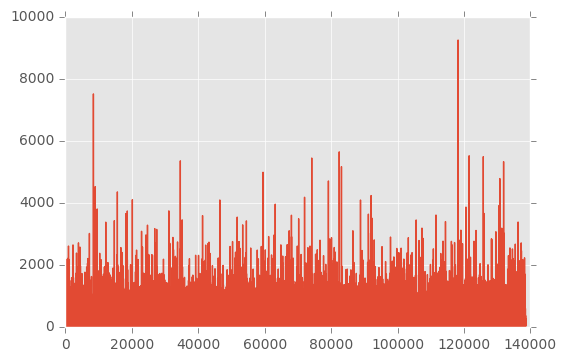

In [4]:
usersRatingCount = data.map(lambda rating: (rating['userId'],1)).countByKey().items()
plt.plot(*zip(*usersRatingCount));

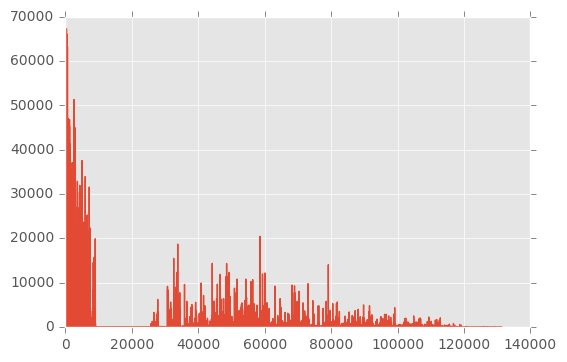

In [5]:
moviesRatingCount = sorted(data.map(lambda rating: (rating['movieId'],1)).countByKey().items())
plt.plot(*zip(*moviesRatingCount));

In [10]:
def isValidation(rating):
    if rating['timestamp']%10 in [1,2]:
        return True
    return False
def isTraining(rating):
    return not isValidation(rating)
training, validation = (data.filter(f) for f in(isTraining,isValidation))

In [97]:
trainingSize = training.count()
validationSize = validation.count()
print("Ratio of training is %2.f and validation is %2.f"%(trainingSize/numRatings*100,validationSize/numRatings*100))

KeyboardInterrupt: 

In [19]:
mu = training.map(lambda rating: rating['rating']).mean()

In [25]:
alpha = training.map(lambda rating: (rating['userId'],rating['rating']-mu)).groupByKey().mapValues(list).map(lambda rating: (rating[0],np.mean(rating[1]))).collectAsMap()

In [30]:
beta = training.map(lambda rating: (rating['movieId'],rating['rating']-alpha[rating['userId']]-mu)).groupByKey().mapValues(list).map(lambda rating: (rating[0],np.mean(rating[1]))).collectAsMap()

In [46]:
alphaMean = np.mean(list(alpha.values()))
betaMean = np.mean(list(beta.values()))
validationMap = validation.map(lambda rating: ((rating['userId'],rating['movieId']),rating['rating'])).collectAsMap()

In [89]:
estimatedMap = defaultdict(lambda: {})
for userId, movieId in validationMap.keys():
    estimatedMap[userId][movieId] = np.clip(mu+alpha.get(userId,alphaMean)+beta.get(movieId,betaMean),0.5,5.0)

In [76]:
numUsers = data.map(lambda rating: rating['userId']).distinct().count()    

In [124]:
def error(estimate):
    sumU = 0
    numUsers = 0
    for user in estimate.keys():
        sumM = 0
        numMovies = 0
        for movie, rating in estimate[user].items():
            sumM += (rating-validationMap[(user,movie)])**2
            numMovies += 1
        sumU += np.sqrt(1./numMovies*sumM)
        numUsers += 1
    return 1./numUsers*sumU
error(estimatedMap)

0.86693421039450358

# 3.2.2 Matrix-factorization model

In [139]:
model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),5,lambda_=0.0001)
prediction = model.predictAll(validation.map(lambda rating: (rating['userId'],rating['movieId'])))
estimation = prediction.collect()
estimatedMap2 = defaultdict(lambda: {})
for userId, movieId, rating in estimation:
    estimatedMap2[userId][movieId] =rating

In [130]:
error(estimatedMap2) # rank =25

1.1871482170678893

In [132]:
error(estimatedMap2) # rank = 12

0.9404401945716474

In [136]:
error(estimatedMap2) # rank =5, lambda = 10.0

3.7452269667338722

In [138]:
error(estimatedMap2) # rank =5, lambda = 0.5

1.0131218972771603

In [128]:
error(estimatedMap2) # rank =5, lambda = 0.0001

0.8524675667492102

In [140]:
error(estimatedMap2) # rank =5, lambda = 0.00001

0.88821879272498194